# SMBH luminosity function

Juan Urrutia, December 2025

## Imports

In [342]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, stats
from scipy.misc import derivative
from scipy.interpolate import RegularGridInterpolator,interp1d,LinearNDInterpolator, BSpline, make_interp_spline
from scipy.integrate import quad, fixed_quad, quadrature, simps, romberg, trapezoid, nquad
from scipy.optimize import root_scalar
from IPython.display import display, Math
import pickle
import os

## General Cosmology

In [ ]:
#Constants and cosmological parameters 
kpc=1;
s=1;
kg=1;
meter = 3.24e-20*kpc;
G = 6.674e-11*meter**3/kg/s**2;
c = 2.998e8*meter/s;
Msun = 1.99e30*kg;
h = 0.674;
𝛔8 = 0.811;
ΩM = 0.315;
Ωb = 0.0493;
zeq = 3402;
T0 = 2.7255;
ns = 0.965;

#Densities

def solve_Omega_R():
    return ΩM * (1 + zeq)**3 / (1 + zeq)**4    
ΩR = solve_Omega_R()
ΩL = 1 - ΩM - ΩR
Ωc = ΩM - Ωb
H0 = 100 * h * meter
def AH(z):
    return np.sqrt(ΩM * (1 + z)**3 + ΩR * (1 + z)**4 + ΩL)
def H(z):
    return H0 * AH(z)
def ΩMz(z):
    return ΩM * (1 + z)**3 / AH(z)**2
def ΩLz(z):
    return ΩL / AH(z)**2
𝜌c = 3 * H0**2 / (8 * np.pi * G)
Ω0 = 0.32
Ωb = 0.05
𝜌0 = Ω0 * 277.5 * h**2
𝜌M0 = 𝜌c * ΩM / Msun * kpc**3
keq = H(zeq)/(1+zeq)*kpc/c;

# Distances
z_grid = np.arange(-6, 4.01, 0.01)
z_vals = 10 ** z_grid
dc_points = []
for z in z_vals:
    if z == 0:
        dc_points.append(0)
    else:
        integrand = lambda x: c / H(x) / kpc
        val, _ = quad(integrand, 0, z)
        dc_points.append(val)
dc = interp1d(z_vals, dc_points, kind='linear', fill_value="extrapolate")

def DVc(z):
    dz = 1e-5
    dcdz = (dc(z + dz) - dc(z- dz)) / (2*dz)
    return 4 * np.pi * dc(z)**2 * dcdz
    
def zDLf(DL):
    def func(z):
        return (1 + z) * dc(z) - DL
    sol = root_scalar(func, bracket=[0, 2e3], method='brentq')
    return sol.root if sol.converged else np.nan
def DLz(z):
    return (1 + z) * dc(z)
    
def tza(z):
    integrand = lambda x: 1 / ((1 + x) * H(x))
    return quad(integrand, z, np.inf)[0]
tz_points = np.concatenate([np.linspace(-0.999, 0, 200), np.linspace(0.0001, 100, 300)])
tz_vals = [tza(z) for z in tz_points]
tz = interp1d(tz_points, tz_vals, kind='cubic', fill_value="extrapolate")
zt = interp1d(tz_vals, tz_points, kind='cubic', fill_value="extrapolate")

#Growth of perturbations

def Dg(z):
    return 5/2*ΩMz(z)/(ΩMz(z)**(4/7)-ΩLz(z)+(1+ΩMz(z)/2)*(1+ΩLz(z)/70))/(1+z)/0.78694
def 𝛿(z):
    return 3 * (12 * np.pi)**(2/3) / 20 * (1 + 0.123 * np.log10(ΩL * (1 + z)**3 / (ΩL * (1 + z)**3 + 1 -ΩL)))
def 𝛿c(z):
    return 3 / 5 * (3 * np.pi / 2)**(2/3) / Dg(z)

In [3]:
# Matter power spectrum

def T(kk):
    ksilk = 1.6 * (Ωb * h**2)**0.52 * (ΩM * h**2)**0.73 * (1 + (10.4 * ΩM * h**2)**-0.95) / 1e3
    a1 = (46.9 * ΩM * h**2)**0.67 * (1 + (32.1 * ΩM * h**2)**-0.532)
    a2 = (12.0 * ΩM * h**2)**0.424 * (1 + (45.0 * ΩM * h**2)**-0.582)
    b1 = 0.944 * (1 + (458 * ΩM * h**2)**-0.708)**-1
    b2 = (0.395 * ΩM* h**2)**(-0.026)
    alpha_cnum = a1**(-Ωb / ΩM) * a2**(-(Ωb / ΩM)**3)
    beta_cnum = 1 / (1 + b1 * ((Ωc / ΩM)**b2 - 1))
    def q(k): return k / (13.41 * keq)
    def C1(k, alpha_c): return 14.2 / alpha_c + 386 / (1 + 69.9 * q(k)**1.08)
    def To1(k, alpha_c, beta_c): return np.log(np.e + 1.8 * beta_c * q(k)) / (np.log(np.e + 1.8 * beta_c * q(k)) + C1(k, alpha_c) * q(k)**2)
    s2 = 44.5 * np.log(9.83 / (ΩM * h**2)) / np.sqrt(1 + 10 * (Ωb * h**2)**(3/4)) * 1e3
    def f(k): return 1 / (1 + (k * s2 / 5.4)**4)
    def Tc(k): return f(k) * To1(k, 1, beta_cnum) + (1 - f(k)) * To1(k, alpha_cnum, beta_cnum)
    def jo(x): return np.sin(x) / x
    def g2(y): return y * (-6 * np.sqrt(1 + y) + (2 + 3 * y) * np.log((np.sqrt(1 + y) + 1) / (np.sqrt(1 + y) - 1)))
    zeq = 2.50e4 * ΩM * h**2 * (T0 / 2.7)**-4
    b3 = 0.313 * (ΩM * h**2)**-0.419 * (1 + 0.607 * (ΩM * h**2)**0.674)
    b4 = 0.238 * (ΩM * h**2)**0.223
    zd = 1291 * (ΩM * h**2)**0.251 / (1 + 0.659 * (ΩM * h**2)**0.828) * (1 + b3 * (Ωb * h**2)**b4)
    Rd = 31.5 * Ωb * h**2 * (T0 / 2.7)**-4 * (zd / 1e3)**-1
    alpha_b = 2.07 * keq * s2 * (1 + Rd)**(-3/4) * g2((1 + zeq) / (1 + zd))
    beta_b = 0.5 + Ωb / ΩM + (3 - 2 * Ωb / ΩM) * np.sqrt(1 + (17.2 * ΩM * h**2)**2)
    beta_node = 8.41 * (ΩM * h**2)**0.435
    def s3(k): return s2 / (1 + (beta_node / (k * s2))**3)**(1/3)
    def Tb(k): return (To1(k, 1, 1) / (1 + (k * s2 / 5.2)**2) + alpha_b / (1 + (beta_b / (k * s2))**3) * np.exp(-(k / ksilk)**1.4)) * jo(k * s3(k))
    return Ωb / ΩM * Tb(kk) + Ωc / ΩM * Tc(kk)
    
def CapitalDelta(k):
    delta_h = 0.00005
    return np.sqrt(delta_h**2 * (c * k / H0)**(3 + ns) * np.abs(T(k))**2)

def P(k):
    return CapitalDelta(k)**2 * (2 * np.pi**2) / k**3

def j1(x):
    return (x * np.cos(x) - np.sin(x)) / x**2

R8 = 8 / h * 1e3

### DM dependent terms

In [4]:
# Matter density variance in CDM 
def WFT(x):
   return 3*(np.sin(x)-x*np.cos(x))/(x**3)
def 𝛔f(M):
    def r(Mc):
        return (3*Mc/(4*np.pi*𝜌M0))**(1/3)
    val, _ = quad(lambda logk:10**(3*logk) * WFT(r(M)*10**logk)**2 * P(10**logk), -20, 20, epsrel=1e-2)
    return 1/(np.sqrt(2)*np.pi) * np.sqrt(np.log(10)*val)
    
log10m_vals = np.arange(-16, 32.1, 0.1)
m_vals = 10**log10m_vals
𝛔2_vals = np.array([𝛔f(m) for m in m_vals])
𝛔2_interp = make_interp_spline(m_vals, 𝛔2_vals, k=1)
def 𝛔CDM2(M):
    ref_mass = 2.7803939422903778e14
    return 𝛔8 / 𝛔2_interp(ref_mass) * 𝛔2_interp(M)
𝛔CDM_vals = np.array([𝛔CDM2(m) for m in m_vals])
𝛔CDM = make_interp_spline(m_vals,𝛔CDM_vals, k=1)
d𝛔dM= 𝛔CDM.derivative()

## GW physics

In [489]:
def m1m2(Mt, eta):
    delta = np.sqrt(1.0 - 4.0 * eta)
    m1 = 0.5 * Mt * (1.0 + delta)
    m2 = 0.5 * Mt * (1.0 - delta)
    return m1, m2
    
def fGW(Mc, fref, beta):
    return fref * (Mc / 1e9) ** (-beta)

def tenvptGW(f, Mc, fref, beta, alpha, z):
    return ((1 + z) * f / fGW(Mc, fref, beta)) ** alpha


def McEta(m1, m2):
    return {
        'Mc': (m1 * m2)**(3/5) / (m1 + m2)**(1/5),
        'eta': (m1 * m2) / (m1 + m2)**2
    }

def tf(f, Mc, z):
    return (1 + z) * 5 * c**5 / (256 * (np.pi * (1 + z) * f / s)**(8/3) * (G * Mc * Msun)**(5/3))

def Adtdf(f, Mc, z):
    return -derivative(lambda x: tf(x, Mc, z), f, dx=1e-11) 

def dOmega(Mc, z, f):
    return 2 * np.pi / 5 * (Adtdf(f, Mc, z) * f)**(-1) * f**3 * (Amp(Mc, (1 + z) * dc(z), z) * f**(-7/6))**2 / (G * 𝜌c * s**2)

def MclogOmega(logOmega, z, f):
    target = 10**logOmega
    root_fun = lambda Mc: dOmega(Mc, z, f) - target
    sol = optimize.root_scalar(root_fun, bracket=[1e-12, 1e12])
    return sol.root

def dlnMcdlogOmega(logOmega, z, f):
    return derivative(lambda x: MclogOmega(x, z, f), logOmega, dx=1e-6) / MclogOmega(logOmega, z, f)

def tenv(Mchirp, f, alpha, beta_, fref):
    return 4 * tins(f, Mchirp) * ((Mchirp / 10**9)**(alpha - beta_) * (f / fref)**alpha)

def _r_from_freq(F, Mchirp):
    return (s * (G * Msun * Mchirp)**0.5 / (np.pi * F))**(2/3) / kpc

def teff(logr, alpha, beta_, fref, Mchirp):
    r_min = _r_from_freq(3 * 10**(-8), Mchirp) * 10**3
    r_max = _r_from_freq(10**(-9), Mchirp) * 10**3
    gate = np.heaviside(logr - np.log10(r_min), 0.0) * np.heaviside(np.log10(r_max) - logr, 0.0)
    f_at_r = fr(10**(logr - 3), Mchirp)
    inv1 = (10**6 * year)**(-1) * tins(f_at_r, Mchirp) * 4
    inv2 = (10**6 * year)**(-1) * tenv(Mchirp, f_at_r, alpha, beta_, fref)
    return np.log10(gate * 1 / (1 / inv1 + 1 / inv2))

## EPS structure formation and merger rates

In [265]:
#Basic probabilities 

def pfcST(δ1,S1): return 0.114963*S1**(-3/2)*np.e**(-0.4*δ1**2/S1)*δ1*(1+1.06923*(δ1**2/S1)**(-3/10))
def δel(δ1,S1): return np.sqrt(0.707)*δ1*(1+0.485*(0.707*δ1**2/S1)**(-0.615))
def pfc(δ1,S1,δ2,S2): 
    return np.e**(-(0.840833*δ1+S2**0.615*(0.504729/δ1**0.23-0.504729/δ2**0.23)-0.840833*δ2)**2/(2*(S1-S2)))*(S1-S2)**(-3/2)*(1+0.90121*(δ1**2/S1)**(3/10))*((S1*δ2**2)/(S2*δ1**2))**(3/10)*np.abs(0.840833*δ1+S2**(0.615)*(0.504729/δ1**0.23-0.504729/δ2**0.23)-0.840833*δ2)/(np.sqrt(2*np.pi)*(1+0.90121*(δ2**2/S2)**(3/10)))
def pcond(δp,𝛔p,δm,𝛔m):
    return pfc(δp,𝛔p**2,δm,𝛔m**2)*pfcST(δm,𝛔m**2)/pfcST(δp,𝛔p**2)
#halo mass functions
def dndlogm(M,z):
    return 𝜌0*2*𝛔CDM(M)*np.abs(d𝛔dM(M))*pfcST(δc(z),𝛔CDM(M)**2)

In [318]:
# Probability of a  merger
def dPdM0dt(M,M0,z):
    S = 𝛔CDM(M)**2
    S0 = 𝛔CDM(M0)**2
    a = 0.707
    p = 3/10
    q = 8/10
    nu = 𝛿c(z)**2/S
    nu0 = 𝛿c(z)**2/S0
    A = (1+(a*(𝛿c(z)**2/S0))**(-p))**(-1)
    def ddelta(z):
        return np.abs((δel(𝛿c(z+1e-5),S0)-δel(𝛿c(z-1e-5),S0))/(2*1e-5))
    return  A/np.sqrt(2*np.pi)*(1+(a*nu)**(-p))*(1+(q*nu0)**(-p))/(1+(q*nu)**(-p))*(S/(S0*(S-S0)))**(3/2)*np.exp(-q*(nu0-nu)/2)*ddelta(z)*(1+z)*H(z)*np.abs(2*𝛔CDM(M0)*d𝛔dM(M0))

In [326]:
# CDM merger rate in elliptical collapse
def Rloglog(M1, M2, z):
    Mp = min(M1, M2)
    M = M1 + M2
    return dndlogm(Mp,z)*M*dPdM0dt(Mp,M,z)

In [ ]:
# We first compute the stellar halo mass relation, 

def Az(z):
    return 0.046 * (1.0 + z) ** (-0.38)

def logMaz(z):
    return 11.79 + 0.2 * z

def Gamma_z(z):
    return 0.709 * (1.0 + z) ** (-0.18)

def Beta_z(z):
    return 0.043 * z + 0.92

def Mstar(Mh, z):
    denom = (Mh / (10.0 ** logMaz(z))) ** (-Beta_z(z)) + (Mh / (10.0 ** logMaz(z))) ** (Gamma_z(z))
    return 2.0 * Az(z) * Mh * (denom ** (-1.0))

def Mbulge(mstar):
    return 0.615 * mstar

def logMBH(Mh, z, a, b, c):
    Ms = Mstar(Mh, z)
    return a + b * np.log10(Ms / (10.0 ** 11)) + c * np.log10(1.0 + z)

def logMh(MBH, z, a, b, c):
    def f(Mh):
        return logMBH(Mh, z, a, b, c) - np.log10(MBH)
    Mh_root = optimize.newton(f, np.log10(MBH) + 2.0)
    return np.log10(Mh_root)

# We then connect the mass of the black hole to the mass of the host galaxy
def pMBH(mbh, Mh, z, a, b, c, sigma):
    mu = logMBH(Mh, z, a, b, c)
    return stats.norm.pdf(np.log10(mbh), loc=mu, scale=sigma)

def logmvMin(mbh, z, a, b, c, sigma):
    def g(x):
        return np.log10(pMBH(mbh, x, z, a, b, c, sigma))+8
    x_root = root_scalar(g, bracket=[1e6, 1e16], method='brentq').root
    return np.log10(x_root)

## Nanograv data and SMBH data

In [41]:
prob = np.load("30f_fs{hd}_ceffyl/density.npy")
year = 365.25 * 24 * 60 * 60
L10rho = np.load("30f_fs{hd}_ceffyl/log10rhogrid.npy")
fNG15 = np.load("30f_fs{hd}_ceffyl/freqs.npy")
DeltafNG15 = np.diff(fNG15)[0]

data = [np.vstack((L10rho, np.exp(prob[j]))).T for j in range(prob.shape[0])]

def OmegaGW(DeltaT, f):
    return 8 * np.pi**4 * (DeltaT**2) * (f**5) * (16.03 * year) / (s * H0)**2

PNG15_interp = [interp1d(d[:,0], d[:,1], kind='linear', bounds_error=False, fill_value=0.0) for d in data]

class ProbabilityDistribution:
    def __init__(self, pdf_func, a, b):
        self.pdf = pdf_func
        self.a = a
        self.b = b

def _normalize_pdf(pdf_func, a, b, n=10000):
    xs = np.linspace(a, b, n)
    vals = pdf_func(xs)
    area = np.trapz(vals, xs)
    if area == 0:
        return lambda x: 0*x
    return lambda x: pdf_func(x) / area

PNG15 = [ProbabilityDistribution(_normalize_pdf(PNG15_interp[i], data[i][0,0], data[i][-1,0]), data[i][0,0], data[i][-1,0]) for i in range(len(PNG15_interp))]
PNG15 = list(zip(fNG15, PNG15))
PNG15 = PNG15[:14]

def RandomVariate(Pdist, size):
    a, b = Pdist.a, Pdist.b
    xs_grid = np.linspace(a, b, 10000)
    pdf_vals = Pdist.pdf(xs_grid)
    M = np.max(pdf_vals)
    samples = []
    rng = np.random.default_rng()

    while len(samples) < size:
        x_prop = rng.uniform(a, b, size - len(samples))
        u = rng.uniform(0, M, size - len(samples))
        accept = u < Pdist.pdf(x_prop)
        samples.extend(x_prop[accept])
    return np.array(samples)

def findlogOmegaDist(Pf):
    f = Pf[0]
    Pdist = Pf[1]
    rv = RandomVariate(Pdist, 5_000_000)
    y = np.log10(OmegaGW(10.0**rv, f))
    bins = np.round(y / 0.01) * 0.01
    uniq, counts = np.unique(bins, return_counts=True)
    dens = counts * (0.01 / 5_000_000.0)
    return interp1d(uniq, dens, kind='nearest', bounds_error=False, fill_value=0.0)

PNG15logOmega = []

for j in range(len(PNG15)):
    f, Pdist = PNG15[j]
    interp0 = findlogOmegaDist(PNG15[j])
    xmin = np.min(interp0.x)
    xmax = np.max(interp0.x)
    PNG15logOmega.append((f, ProbabilityDistribution(_normalize_pdf(interp0, xmin, xmax), xmin, xmax)))

In [42]:
# Load the pre-processed data
with open("agn_data.pkl", "rb") as f:
    data = pickle.load(f)

# Extract the variables
broadLINEAGNdata = data["broadLINEAGNdata"]
otherAGNdata = data["otherAGNdata"]
dynamicallymeasured = data["dynamicallymeasured"]

print(f"Loaded {len(broadLINEAGNdata)} broad AGN data points")
print(f"Loaded {len(otherAGNdata)} other AGN data points")
print(f"Loaded {len(dynamicallymeasured)} dynamically measured data points")

Loaded 235 broad AGN data points
Loaded 27 other AGN data points
Loaded 70 dynamically measured data points


## Luminosity function of SMBHs

In [487]:
def Rastro(m1, m2, z, a, b, sigma):
    def integrand(logM1, logM2):
        return (
            Rloglog(10**logM1, 10**logM2, z)
            * pMBH(m1, 10**logM1, z, a, b, 0, sigma)
            * pMBH(m2, 10**logM2, z, a, b, 0, sigma)
        )
    r1 = [8, 18.0]
    r2 = [8, 18.0]
    return nquad(integrand, [r1, r2], opts=[{'epsrel': 1e-3}, {'epsrel': 1e-3}])[0]

def PlogOmega0astro(logOmega, f, pbh, fref, alpha, beta, a, b, sigma):
    def integrand(eta, z):
        Mc = MclogOmega(logOmega, z, f)
        m1, m2 = m1m2(Mc, eta)
        return (
           2.0/ (np.sqrt(1.0 - 4.0 * eta) * eta)
            * 0.69
            * Adtdf(f, Mc, z) * f / (1.0 + tenvptGW(f, Mc, fref, beta, alpha, z) ** (-1.0))
            * DVc(z) / (1.0 + z)
            * pbh
            * Rastro(m1, m2, z, a, b, sigma)
        )
    r_eta = [1e-3,0.25]
    r_z = [0.0, 3.0]
    return nquad(integrand, [r_eta, r_z], opts=[{'epsrel': 1e-1,'limit':1}, {'epsrel': 1e-1,'limit':1}])[0]

In [490]:
 PlogOmega0astro(-9, 1e-9, 1, 15*10**-9, 5/8, 8/3, 9, 1.5, 0.5)

/var/folders/pg/30zt2zh52p546f6kb2dn1w9m0000gn/T/ipykernel_1428/3946413751.py:24: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return -derivative(lambda x: tf(x, Mc, z), f, dx=1e-11)


91.77955680171104

In [328]:
yvalues=[np.log10(Rastro(1e8, 10**logm, 0., 9., 1.4, 0.5)) for logm in np.linspace(6, 10, 25)]
xvalues=[z for z in np.linspace(6, 10, 25)]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


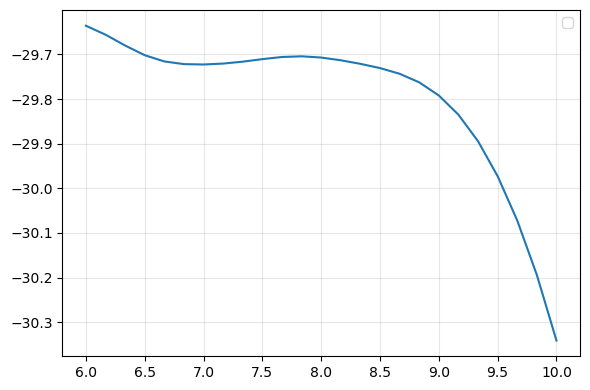

In [ ]:
# Plot
plt.figure(figsize=(6, 4))
plt.plot(xvalues, yvalues)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()